  File "c:\Users\asia\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\asia\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\asia\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\asia\anaconda3\Lib\subprocess.py",


[1. 알고리즘별 성능 비교 결과 (Seed: 42)]
                 Model Accuracy Precision   Recall F1-Score  ROC-AUC
0  Logistic Regression   0.6436    0.6022   0.5023   0.5477  0.7271*
4    Gradient Boosting  0.6624*   0.6295*   0.5207   0.5700   0.7235
1        Random Forest   0.6416    0.6023   0.4885   0.5394   0.7103
3             LightGBM   0.6515    0.6046  0.5461*  0.5738*   0.7073
2              XGBoost   0.6149    0.5591   0.4908   0.5227   0.6681
5                 K-NN   0.6020    0.5417   0.4793   0.5086   0.6282
------------------------------------------------------------
결과 해석: 가장 좋은 성능의 모델은 [Logistic Regression]입니다.
 - Accuracy: 0.6436
 - Precision: 0.6022
 - Recall: 0.5023
 - F1-Score: 0.5477
 - ROC-AUC: 0.7271
------------------------------------------------------------

[2. 변수별 영향력(우선순위) 확인]


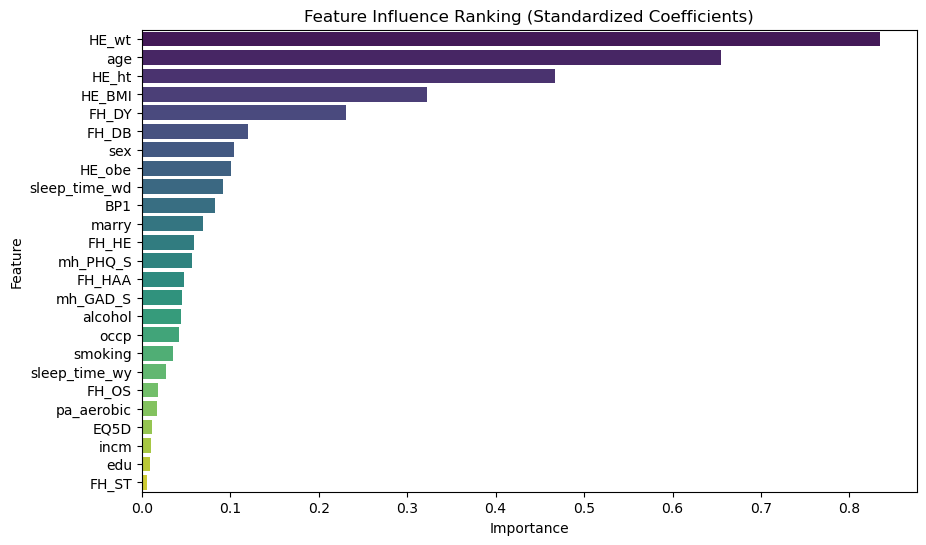

엑셀 파일 저장 완료: D:/semi2/MH/df/질환별/이상지질혈증_모델성능비교.xlsx


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # 표준화 도구
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')

# [고정] 모든 난수 시드 고정 (결과 재현성 확보)
SEED = 42
np.random.seed(SEED)

# 1. 데이터 로드
# 실제 파일 경로와 인코딩 확인 필수
file_path = 'D:/semi2/MH/df/질환별/이상지질혈증.csv' # 예시 경로
df = pd.read_csv(file_path, encoding='cp949')

# [중요] 분석에 사용할 특성(X)과 정답(y) 컬럼명 매칭
# 본인의 실제 데이터 파일에 있는 컬럼명으로 수정하세요.
features = ['age', 'sex', 'edu', 'incm', 'occp', 'marry', 'FH_HE',
'FH_DY', 'FH_HAA', 'FH_ST', 'FH_DB', 'FH_OS' , 'HE_obe', 'HE_ht', 'HE_wt', 'HE_BMI', 'smoking', 'alcohol', 'pa_aerobic', 'sleep_time_wy', 'sleep_time_wd', 'mh_PHQ_S', 'mh_GAD_S', 'BP1', 'EQ5D']
target = 'clinical_DY' # 이상지질혈증 유무 (0 또는 1)

X_raw = df[features]
y = df[target]

# 2. 데이터 분할 (학습용 80%, 테스트용 20%)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=SEED)

# ---------------------------------------------------------
# [핵심] 표준화 전처리 로직 (Standardization)
# ---------------------------------------------------------
scaler = StandardScaler()


# 학습 데이터(Train)를 기준으로 평균과 표준편차를 학습하고 변환
X_train = scaler.fit_transform(X_train_raw)

# 테스트 데이터(Test)는 학습 데이터의 기준을 그대로 적용하여 변환
X_test = scaler.transform(X_test_raw)
# ---------------------------------------------------------

# 3. 알고리즘 리스트 (모든 모델 SEED 고정)
models = [
    ("Logistic Regression", LogisticRegression(random_state=SEED)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=SEED)),
    ("XGBoost", XGBClassifier(eval_metric='logloss', random_state=SEED)),
    ("LightGBM", LGBMClassifier(verbose=-1, random_state=SEED)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=SEED)),
    ("K-NN", KNeighborsClassifier())
]

# 4. 학습 및 성능 평가
perf_results = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    
    perf_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

# 5. 결과 가공 (지표별 최대값에 별표 추가)
comparison_table = pd.DataFrame(perf_results).sort_values(by="ROC-AUC", ascending=False)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

highlighted_table = comparison_table.copy()
for metric in metrics:
    max_val = comparison_table[metric].max()
    highlighted_table[metric] = comparison_table[metric].apply(
        lambda x: f"{x:.4f}*" if x == max_val else f"{x:.4f}"
    )

# 6. 영향력(변수 중요도) 추출 - 로지스틱 회귀 기준
lr_model = LogisticRegression(random_state=SEED)
lr_model.fit(X_train, y_train)
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(lr_model.coef_[0])
}).sort_values(by='Importance', ascending=False)

# 7. 최종 결과 출력
print(f"\n[1. 알고리즘별 성능 비교 결과 (Seed: {SEED})]")
# 코랩 환경 대응 출력
try:
    from google.colab import data_table
    display(highlighted_table)
except:
    print(highlighted_table)

# 최우수 모델 분석 요약
best_model_row = comparison_table.iloc[0]
print("-" * 60)
print(f"결과 해석: 가장 좋은 성능의 모델은 [{best_model_row['Model']}]입니다.")
print(f" - Accuracy: {best_model_row['Accuracy']:.4f}")
print(f" - Precision: {best_model_row['Precision']:.4f}")
print(f" - Recall: {best_model_row['Recall']:.4f}")
print(f" - F1-Score: {best_model_row['F1-Score']:.4f}")
print(f" - ROC-AUC: {best_model_row['ROC-AUC']:.4f}")
print("-" * 60)

# 8. 영향력 시역화
print("\n[2. 변수별 영향력(우선순위) 확인]")
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Influence Ranking (Standardized Coefficients)')
plt.show()

# 엑셀 파일로 저장
output_path = "D:/semi2/MH/df/질환별/이상지질혈증_모델성능비교.xlsx"
highlighted_table.to_excel(output_path, index=False)

print(f"엑셀 파일 저장 완료: {output_path}")